In [1]:
import pandas as pd
from malariagen_data.pv4 import Pv4
import numpy as np
import os
import allel
from itertools import compress
import matplotlib.pyplot as plt

Notes 

* I don't have results for chrom 14 

# Load Data 

In [2]:
results_df = pd.read_csv("sliding_window_results/compiled_windowed_heterozygosity.csv")

Here we provide a map of the P. vivax heterozygome. Chromosomal distribution of all windows identified in the global set of high-quality, independent monoclonal infections with at least 1 SNP. Each point is an identified window, with the size increasing as the number of SNPs within the window increases. Potential microhaplotype regions are well distributed across the 14 chromosomes. The microhaplotypes with the highest SNP densities tend to be located at the ends of the chromosomes. Note, microhaplotypes were selected only from the accessible regions of the genome i.e., excluding highly diverse telomeric and sub-telomeric regions where sequence reads could not be mapped accurately. 

In [3]:
man_colours = ['#C62828','#D81B60','#8E24AA','#5E35B1','#3949AB','#1E88E5','#039BE5','#00ACC1','#00897B','#43A047','#7CB342','#C0CA33','#FFB300','#F4511E']

In [4]:
def plot_man(df):

    rcParams = plt.rcParams
    rcParams['font.size'] = 14
    rcParams['axes.labelsize'] = 14

    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=12

    fig, ax = plt.subplots(figsize=(16, 7))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_ylim([0,40])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('SNPs in microhaplotype')
    
    colour_i=0
    chrom_num = 0 
    for chrom in df.chrom.unique(): 
        chrom_num += 1
        chrom_df = df.loc[df['chrom']==chrom]
        windows = chrom_df.shape[0]
        increment = 1/windows
        delta = 0
        x = chrom_num - (windows*increment/2)
        for index, row in chrom_df.iterrows():
            ax.scatter(x, row['variant_counts'], c=man_colours[colour_i],s=row['variant_counts'])
            x+=increment
        colour_i+=1
    plt.xticks(np.arange(1, 15, 1.0), rotation = 45)

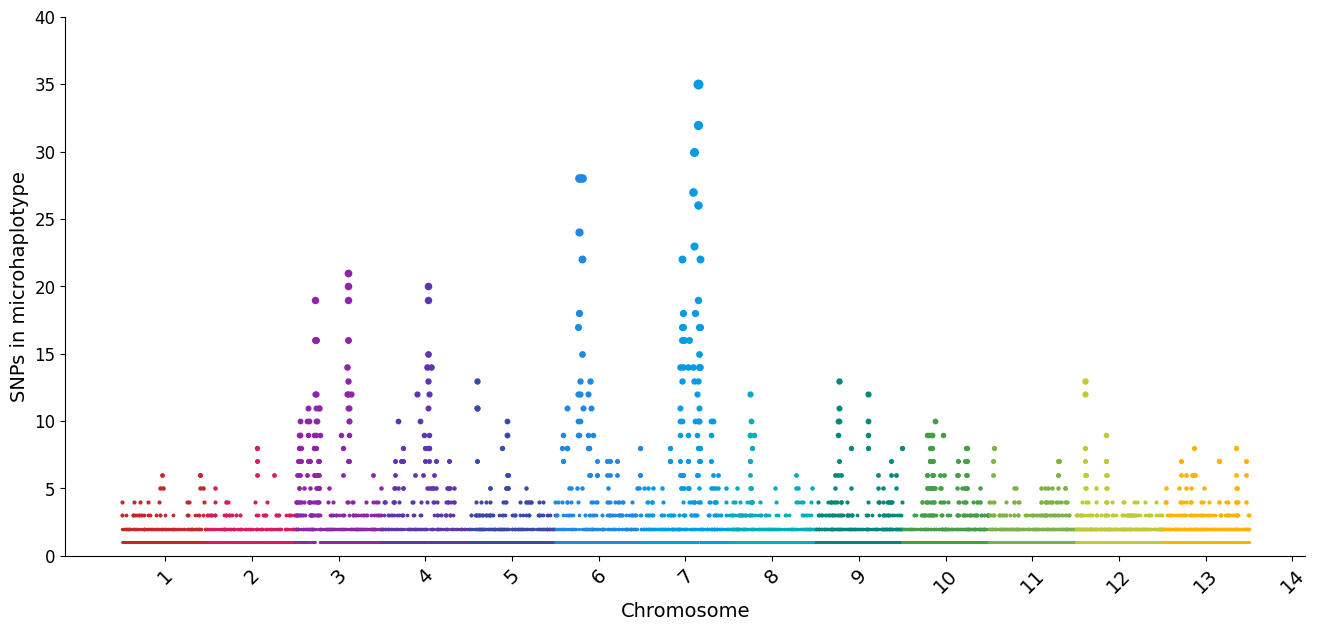

In [5]:
plot_man(results_df)

# Select Microhaplotypes 

We generated two new microhaplotype panels for this analysis; "Random-SNP panel" and "High-diversity SNP panel" 
* each contains 100 microhaplotypes 
* minimum het >= 0.5 
* roughly evenly spaced across 14 chroms 

High-diversity SNP panel 
* 3-10 SNPs 
* optimised for highest heterozygosity 

Random-SNP panel 
* Any number of SNPs randomly chosen 

In [6]:
# This number is different to the paper 
sum(results_df.het >= 0.5)

3347

In [137]:
results_df.shape

(11806, 11)

# Compared to Sasha's set 

In [7]:
# Load from file 
final_3_10_SNP = pd.read_csv("20200511_mhap_GTs_global_mhap_identifiers_3_10_SNP.tsv", sep='\t')
final_3_10_SNP.head()

,chrom,pos,chr_num,hap_idx,BBH-1-125,BBH_1_132,BBH_1_137,BBH_1_153,BBH_1_162,Brazil01,...,india_C0960,india_C1019,india_C1021,india_C1039,india_C1050,india_C1060,malagasy15,malagasy19,malagasy8,mauritania
0,PvP01_01_v1,395356,1,0,b'0/0',b'0/0',b'0/0',b'0/0',b'0/0',b'./.',...,b'0/0',b'./.',b'0/0',b'./.',b'0/0',b'0/0',b'1/1',b'0/1',b'1/1',b'0/0'
1,PvP01_01_v1,395454,1,0,b'0/0',b'0/0',b'0/0',b'0/0',b'0/0',b'./.',...,b'0/0',b'./.',b'1/1',b'./.',b'0/0',b'./.',b'0/0',b'0/0',b'0/0',b'1/1'
2,PvP01_01_v1,395481,1,0,b'0/0',b'0/0',b'0/0',b'0/0',b'0/0',b'./.',...,b'./.',b'0/0',b'1/1',b'./.',b'0/0',b'./.',b'0/0',b'0/0',b'1/1',b'0/0'
3,PvP01_01_v1,395494,1,0,b'1/1',b'1/1',b'1/1',b'1/1',b'1/1',b'./.',...,b'./.',b'1/1',b'1/1',b'./.',b'1/1',b'./.',b'1/1',b'1/1',b'1/1',b'1/1'
4,PvP01_01_v1,395509,1,0,b'1/1',b'1/1',b'1/1',b'1/1',b'1/1',b'./.',...,b'./.',b'1/1',b'1/1',b'./.',b'1/1',b'./.',b'1/1',b'1/1',b'1/1',b'1/1'


In [8]:
# Get start and end of each region and put into data frame 
start = final_3_10_SNP.groupby('hap_idx')['pos'].min()
end = final_3_10_SNP.groupby('hap_idx')['pos'].max()
chrom = [c[0] for c in final_3_10_SNP.groupby('hap_idx')['chrom'].unique()]

final_3_10_SNP_coords = pd.DataFrame(data={'chrom':chrom,'window_start':start,'window_end':end})

In [9]:
final_3_10_SNP_coords

,chrom,window_start,window_end
hap_idx,,,
0,PvP01_01_v1,395356,395521
1,PvP01_01_v1,483736,483883
2,PvP01_01_v1,612226,612348
3,PvP01_01_v1,772094,772211
4,PvP01_02_v1,213959,214133
...,...,...,...
95,PvP01_14_v1,2189681,2189767
96,PvP01_14_v1,2261605,2261794
97,PvP01_14_v1,2699926,2700045


# Match up windows to my microhaplotype candidates 

In [10]:
# Find microhaplotypes from my candidates that start closest to begining of Sasha's 

closest_windows_index = []
closest_windows = []
abs_differences = []

for index, row in final_3_10_SNP_coords.iterrows(): 
    window_start = row.window_start
    index_closest_window_in_my_set = (abs(results_df.window_start-window_start)).idxmin() 
    closest_window = results_df.iloc[index_closest_window_in_my_set]
    difference = (abs(results_df.window_start-window_start)).min() 
    
    closest_windows_index.append(index_closest_window_in_my_set)
    closest_windows.append(closest_window)
    abs_differences.append(difference)

In [11]:
closest_windows_df = results_df.iloc[closest_windows_index]

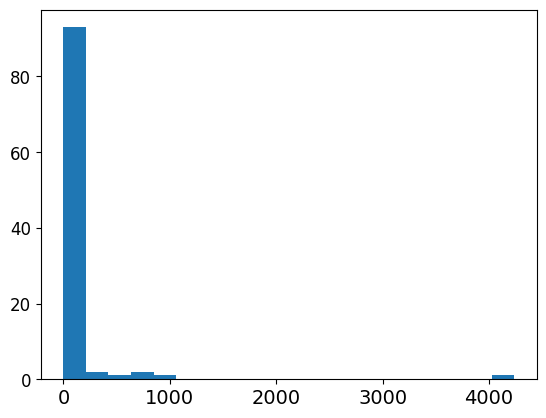

In [13]:
plt.hist(abs_differences, bins=20)
plt.show()

The regions from Sasha start at the first SNP in that microhaplotype, they aren't the full region. Need to check that the SNPs are fully encapsulated by one of the microhaplotype candidates in my list. 

Check below if the start and end of the region in the final list are between the boundaries of one of the regions in my list

In [140]:
distance_from_start_to_first_snp = []
true_matches_index = []
chrom14_count = 0 
for index, row in final_3_10_SNP_coords.iterrows():
    chrom = row.chrom
    snp_start = row.window_start
    snp_end = row.window_end
    
    if chrom != 'PvP01_14_v1':
        results_df_for_chrom = results_df.loc[results_df.chrom==chrom]
        distance_from_start_of_candidate = snp_start - results_df_for_chrom.window_start
        # Only consider candidates that have positive distance 
        min_distance_to_start = distance_from_start_of_candidate.mask(distance_from_start_of_candidate<0).min()
        index_for_region = distance_from_start_of_candidate.mask(distance_from_start_of_candidate<0).idxmin()
        region = results_df.iloc[index_for_region]

        # Check if the end of this region encapsulated the final snp in the microhaplotype
        if region.window_end > snp_end: 
            true_matches_index.append(index_for_region)

        distance_from_start_to_first_snp.append(min_distance_to_start)
    else: 
        chrom14_count +=1

In [141]:
len(true_matches_index)

72

In [142]:
chrom14_count

13

In [100]:
winning_regions_df = results_df.iloc[true_matches_index]
winning_regions_df

,chrom,window_start,window_end,variant_counts,unique_allele_counts,unique_alleles_with_missing_index,unique_alleles_with_het_index,unique_allele_frequencies,unique_allele_count,entropy,het
518,PvP01_01_v1,395343,395542,6,[ 1 65 1 8 1 66 1 10 1 201 20 ...,[0],"[2, 6, 8, 11, 12, 20, 21]","[0.0016260162601626016, 0.10569105691056911, 0...",28,2.203175,0.833488
448,PvP01_01_v1,483693,483892,4,[139 1 12 1 1 13 89 83 1 189 85 1],[],"[1, 3, 4, 8]","[0.22601626016260162, 0.0016260162601626016, 0...",12,1.732804,0.795373
123,PvP01_01_v1,612193,612392,4,[102 1 72 8 8 4 1 53 38 1 42 ...,[],"[1, 6, 9, 12, 13, 14, 16]","[0.16585365853658537, 0.0016260162601626016, 0...",18,2.180597,0.867256
271,PvP01_01_v1,772059,772258,6,[ 1 1 1 1 44 9 1 28 8 1 10 ...,"[0, 1, 2, 3, 6, 12, 17, 18, 19, 22, 34]","[9, 14, 15, 16, 33]","[0.0016260162601626016, 0.0016260162601626016,...",42,2.761664,0.889566
902,PvP01_02_v1,660461,660660,4,[ 1 204 1 2 97 18 33 1 12 2 1 ...,[0],"[3, 7, 10, 11, 15, 18]",[0.00162602 0.33170732 0.00162602 0.00325203 0...,20,2.096393,0.823002
...,...,...,...,...,...,...,...,...,...,...,...
10631,PvP01_13_v1,754721,754920,4,[ 1 1 1 1 2 257 2 70 95 5 1 ...,"[0, 1, 2, 3, 4]","[6, 10, 14, 15, 16, 18]","[0.0016260162601626016, 0.0016260162601626016,...",22,1.804190,0.763477
11757,PvP01_13_v1,1197649,1197848,7,[ 1 48 3 10 3 55 3 16 1 1 1 ...,"[0, 23, 25]","[8, 9, 10, 21, 22, 29]","[0.0016260162601626016, 0.07804878048780488, 0...",36,2.651223,0.900739
11328,PvP01_13_v1,1532499,1532698,3,[ 1 198 282 31 1 1 2 64 1 34],"[0, 8]","[4, 5]","[0.0016260162601626016, 0.32195121951219513, 0...",10,1.328940,0.669644
11481,PvP01_13_v1,1865299,1865498,4,[ 1 153 1 117 140 1 1 29 32 1 10 ...,"[0, 6]","[2, 5, 11]","[0.0016260162601626016, 0.24878048780487805, 0...",15,1.779073,0.803559


In [101]:
# All of these have het > 0.5, some have 10+
print(sum(winning_regions_df.het<0.5))
print(winning_regions_df.variant_counts.value_counts())

0
4     28
3     11
5      9
6      7
7      5
8      4
9      3
13     2
12     1
11     1
10     1
Name: variant_counts, dtype: int64


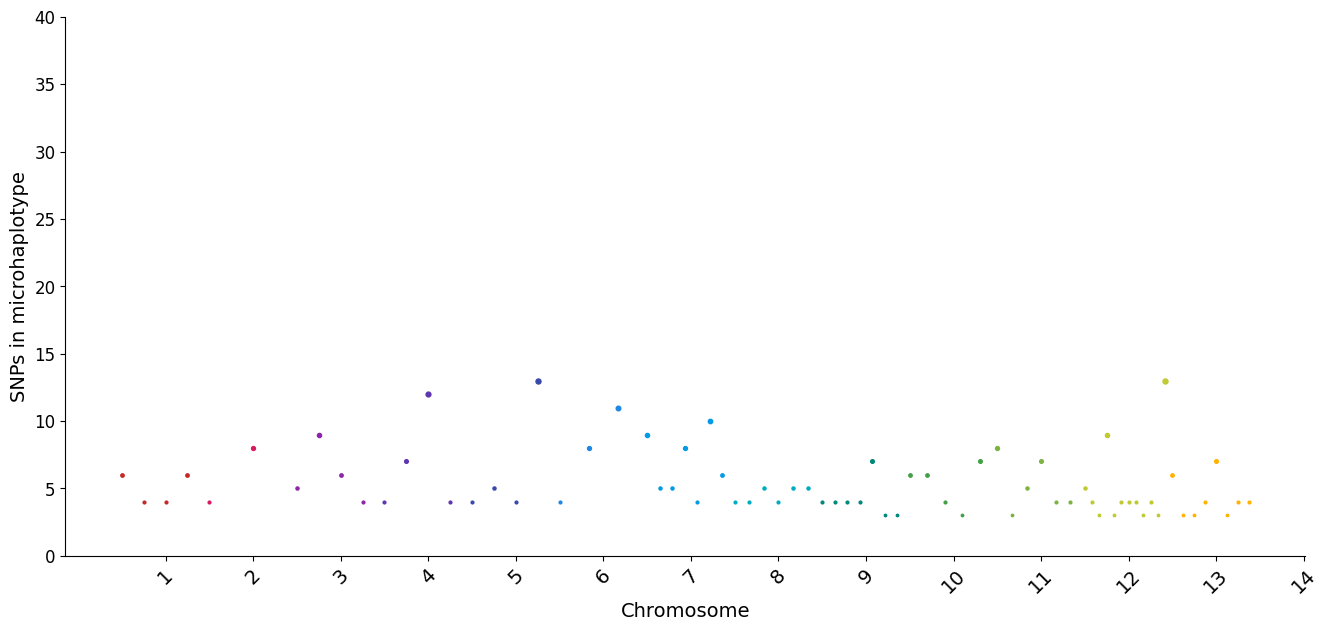

In [102]:
plot_man(winning_regions_df)

In [109]:
winning_regions_df = winning_regions_df.sort_values(['chrom','window_start'])

In [110]:
winning_regions_df['shifted_window_start']=winning_regions_df['window_start'].shift(-1)

In [120]:
distances = winning_regions_df['shifted_window_start'] - winning_regions_df['window_start']

In [123]:
distances = [d for d in distances if d > 0]
distances

[88350.0,
 128500.0,
 159866.0,
 65650.0,
 73100.0,
 284550.0,
 295259.0,
 138400.0,
 262988.0,
 88600.0,
 319800.0,
 286600.0,
 592587.0,
 154800.0,
 244961.0,
 418300.0,
 201000.0,
 134800.0,
 290950.0,
 96750.0,
 207183.0,
 133000.0,
 653850.0,
 195750.0,
 385643.0,
 65250.0,
 307450.0,
 86250.0,
 323022.0,
 294050.0,
 228950.0,
 175950.0,
 50950.0,
 470750.0,
 546494.0,
 115347.0,
 102200.0,
 429950.0,
 815600.0,
 149300.0,
 169371.0,
 208750.0,
 138150.0,
 117600.0,
 206912.0,
 461718.0,
 441850.0,
 46700.0,
 162550.0,
 357500.0,
 257950.0,
 263700.0,
 126100.0,
 192150.0,
 269050.0,
 442928.0,
 334850.0,
 332800.0,
 120350.0]

In [124]:
np.mean(distances)

249385.2372881356

In [126]:
np.std(distances)

158581.8455034047

In [138]:
min(distances)

46700.0

In [129]:
(23*1000000)/100 

230000.0

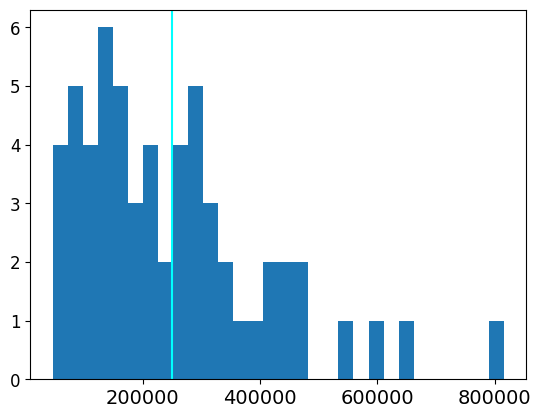

In [136]:
plt.hist(distances, bins=30)
plt.axvline(np.mean(distances), color='cyan')

In [112]:
winning_regions_df

,chrom,window_start,window_end,variant_counts,unique_allele_counts,unique_alleles_with_missing_index,unique_alleles_with_het_index,unique_allele_frequencies,unique_allele_count,entropy,het,shifted_window_start
518,PvP01_01_v1,395343,395542,6,[ 1 65 1 8 1 66 1 10 1 201 20 ...,[0],"[2, 6, 8, 11, 12, 20, 21]","[0.0016260162601626016, 0.10569105691056911, 0...",28,2.203175,0.833488,483693.0
448,PvP01_01_v1,483693,483892,4,[139 1 12 1 1 13 89 83 1 189 85 1],[],"[1, 3, 4, 8]","[0.22601626016260162, 0.0016260162601626016, 0...",12,1.732804,0.795373,612193.0
123,PvP01_01_v1,612193,612392,4,[102 1 72 8 8 4 1 53 38 1 42 ...,[],"[1, 6, 9, 12, 13, 14, 16]","[0.16585365853658537, 0.0016260162601626016, 0...",18,2.180597,0.867256,772059.0
271,PvP01_01_v1,772059,772258,6,[ 1 1 1 1 44 9 1 28 8 1 10 ...,"[0, 1, 2, 3, 6, 12, 17, 18, 19, 22, 34]","[9, 14, 15, 16, 33]","[0.0016260162601626016, 0.0016260162601626016,...",42,2.761664,0.889566,660461.0
902,PvP01_02_v1,660461,660660,4,[ 1 204 1 2 97 18 33 1 12 2 1 ...,[0],"[3, 7, 10, 11, 15, 18]",[0.00162602 0.33170732 0.00162602 0.00325203 0...,20,2.096393,0.823002,726111.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10631,PvP01_13_v1,754721,754920,4,[ 1 1 1 1 2 257 2 70 95 5 1 ...,"[0, 1, 2, 3, 4]","[6, 10, 14, 15, 16, 18]","[0.0016260162601626016, 0.0016260162601626016,...",22,1.804190,0.763477,1197649.0
11757,PvP01_13_v1,1197649,1197848,7,[ 1 48 3 10 3 55 3 16 1 1 1 ...,"[0, 23, 25]","[8, 9, 10, 21, 22, 29]","[0.0016260162601626016, 0.07804878048780488, 0...",36,2.651223,0.900739,1532499.0
11328,PvP01_13_v1,1532499,1532698,3,[ 1 198 282 31 1 1 2 64 1 34],"[0, 8]","[4, 5]","[0.0016260162601626016, 0.32195121951219513, 0...",10,1.328940,0.669644,1865299.0
11481,PvP01_13_v1,1865299,1865498,4,[ 1 153 1 117 140 1 1 29 32 1 10 ...,"[0, 6]","[2, 5, 11]","[0.0016260162601626016, 0.24878048780487805, 0...",15,1.779073,0.803559,1985649.0


In [ ]:
# Look at ones which aren't chrom 14 and don't have a match 

In [144]:
# There are 15 regions which don't have a match in my set 
100-(len(true_matches_index)+chrom14_count)

15

In [145]:
no_match_index = []

for index, row in final_3_10_SNP_coords.iterrows():
    chrom = row.chrom
    snp_start = row.window_start
    snp_end = row.window_end
    
    if chrom != 'PvP01_14_v1':
        results_df_for_chrom = results_df.loc[results_df.chrom==chrom]
        distance_from_start_of_candidate = snp_start - results_df_for_chrom.window_start
        # Only consider candidates that have positive distance 
        min_distance_to_start = distance_from_start_of_candidate.mask(distance_from_start_of_candidate<0).min()
        index_for_region = distance_from_start_of_candidate.mask(distance_from_start_of_candidate<0).idxmin()
        region = results_df.iloc[index_for_region]

        # If the window ends before the last snp add it to the list of no matches 
        if region.window_end < snp_end: 
            no_match_index.append(index)

In [146]:
final_3_10_SNP_coords.iloc[no_match_index]

,chrom,window_start,window_end
hap_idx,,,
4,PvP01_02_v1,213959,214133
5,PvP01_02_v1,327553,327739
18,PvP01_05_v1,501009,501188
20,PvP01_05_v1,1093159,1093327
25,PvP01_06_v1,983158,983333
37,PvP01_08_v1,1279760,1279943
40,PvP01_09_v1,264726,264897
52,PvP01_10_v1,934473,934646
53,PvP01_10_v1,1097784,1097940


In [157]:
results_df_for_chrom = results_df.loc[results_df.chrom=='PvP01_02_v1']
results_df_for_chrom = results_df_for_chrom.sort_values('window_start') 
results_df_for_chrom.loc[(results_df_for_chrom.window_start>213800) & (results_df_for_chrom.window_end<214200)]

,chrom,window_start,window_end,variant_counts,unique_allele_counts,unique_alleles_with_missing_index,unique_alleles_with_het_index,unique_allele_frequencies,unique_allele_count,entropy,het
965,PvP01_02_v1,213811,214010,2,[ 87 117 4 1 396 10],[],"[2, 3]",[0.14146341 0.1902439 0.00650407 0.00162602 0...,6,0.985981,0.528876
964,PvP01_02_v1,213861,214060,3,[ 22 65 36 1 80 4 1 3 393 8 2],[],"[3, 5, 6]",[0.03577236 0.10569106 0.05853659 0.00162602 0...,11,1.228977,0.558599
963,PvP01_02_v1,213961,214160,3,[ 22 3 255 3 204 43 2 1 80 2],[],"[3, 7]",[0.03577236 0.00487805 0.41463415 0.00487805 0...,10,1.401168,0.694888


In [156]:
final_3_10_SNP.loc[(final_3_10_SNP.chrom=='PvP01_02_v1') & (final_3_10_SNP.pos >= 213959) & 
                   (final_3_10_SNP.pos <= 214133)]

,chrom,pos,chr_num,hap_idx,BBH-1-125,BBH_1_132,BBH_1_137,BBH_1_153,BBH_1_162,Brazil01,...,india_C0960,india_C1019,india_C1021,india_C1039,india_C1050,india_C1060,malagasy15,malagasy19,malagasy8,mauritania
20,PvP01_02_v1,213959,2,4,b'1/1',b'1/1',b'1/1',b'1/1',b'1/1',b'1/1',...,b'1/1',b'1/1',b'./.',b'./.',b'1/1',b'./.',b'1/1',b'1/1',b'1/1',b'1/1'
21,PvP01_02_v1,213974,2,4,b'0/0',b'0/0',b'0/0',b'0/0',b'0/0',b'0/0',...,b'0/0',b'0/0',b'./.',b'./.',b'0/0',b'0/0',b'0/0',b'0/0',b'0/0',b'0/0'
22,PvP01_02_v1,214056,2,4,b'1/1',b'1/1',b'1/1',b'1/1',b'1/1',b'1/1',...,b'1/1',b'./.',b'./.',b'./.',b'1/1',b'./.',b'1/1',b'1/1',b'1/1',b'1/1'
23,PvP01_02_v1,214133,2,4,b'0/0',b'1/1',b'1/1',b'1/1',b'0/1',b'1/1',...,b'1/1',b'./.',b'0/0',b'./.',b'0/0',b'0/0',b'0/1',b'0/0',b'1/1',b'1/1'


In [199]:
# # Find windows where the start in my list is less than the start in the final list. 
# # Filter these to only include ones where the end of my region is higher than the end of theirs
# distances = []
# closest_windows_index = []
# true_matches_index = []

# for index, row in final_3_10_SNP_coords.iterrows():
#     window_start = row.window_start
#     window_end = row.window_end
    
#     distances_from_start = (window_start-results_df.window_start)
#     index_closest_window_in_my_set = (distances_from_start.mask(distances_from_start<0)).idxmin()
#     closest_window = results_df.iloc[index_closest_window_in_my_set]
    
#     if closest_window.window_end > window_end: 
#         true_matches_index.append(index_closest_window_in_my_set)
        
#     distances.append(distances_from_start.mask(distances_from_start<0).min())
#     closest_windows_index.append(index_closest_window_in_my_set)

#     print(window_start-closest_window.window_start,closest_window.window_end-window_end)

13 21
43 9
33 44
0 82
98 -73
16 -3
3 46
96 74
30 13
54 37
63 46
46 18
21 67
44 43
13 73
7 60
90 39
12 142
22 -2
42 13
35 -4
10 25
6 14
2 13
47 16
48 -24
27 16
104 3
12 37
17 45
36 36
40 39
22 8
3 47
77 5
39 87
3 22
46 -30
79 30
12 15
42 -14
17 48
79 26
24 38
50 77
1 70
106 9
139 13
116 0
23 12
4 148
16 24
29 -3
96 -53
11 43
38 1
41 19
5 122
21 40
48 -9
18 -2
2 48
23 27
82 31
27 -11
34 144
11 58
3 100
14 7
31 108
39 -34
83 2
20 48
36 11
69 5
75 31
161 3
40 38
12 52
95 12
32 37
27 101
65 17
82 -52
13 20
45 15
50 34
1701 -1653
57 49
0 131
46 -26
771 -583
741 -616
97 -44
492 -397
1114 -1001
4238 -4228
3509 -3429
2502 -2476
764 -715


In [201]:
len(true_matches_index)

74